In [1]:
import findspark
findspark.init('/usr/hdp/spark/')

In [2]:
application_name = 'RandomForest'
master = "yarn"
num_executors = 50
executor_memory = '6G'
driver_memory = '64G'
num_cores = 4

In [3]:
from pyspark.sql import SparkSession
import os 

os.environ["PYTHONHOME"] = "/afs/cern.ch/work/m/migliori/public/anaconda2"
os.environ["PYTHONPATH"] = "/afs/cern.ch/work/m/migliori/public/anaconda2/lib/python2.7/site-packages"

spark = SparkSession.builder\
        .appName(application_name)\
        .config("spark.pyspark.python",
                "/afs/cern.ch/work/m/migliori/public/anaconda2/bin/python")\
        .config("spark.master", master)\
        .config("spark.executor.cores", `num_cores`)\
        .config("spark.executor.instances", `num_executors`)\
        .config("spark.executor.memory", executor_memory)\
        .config("spark.driver.memory", driver_memory)\
        .config("spark.sql.execution.arrow.enabled", "true")\
        .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer")\
        .config("spark.driver.maxResultSize", "64G") \
        .getOrCreate()

In [4]:
spark

## Load train and test dataframes

In [7]:
from __future__ import print_function

In [9]:
%%time
trainDF = spark.read.format('parquet') \
        .load('hdfs://p01001532067275.cern.ch/project/ML/data/trainUndersampled.parquet') \
        .select(['hfeatures_dense', 'label', 'encoded_label'])
        
testDF = spark.read.format('parquet') \
        .load('hdfs://p01001532067275.cern.ch/project/ML/data/testUndersampled.parquet') \
        .select(['hfeatures_dense', 'label', 'encoded_label'])    
        
test_events = testDF.count()
train_events = trainDF.count()
print('There are', train_events, 'training events')
print('There are', test_events, 'test events')

There are 3422692 training events
There are 855993 test events
CPU times: user 7.52 ms, sys: 8.26 ms, total: 15.8 ms
Wall time: 26.9 s


In [10]:
trainDF.printSchema()

root
 |-- hfeatures_dense: vector (nullable = true)
 |-- label: long (nullable = true)
 |-- encoded_label: vector (nullable = true)



## Train the Random Forest

In [76]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(numTrees=100, maxDepth=10,
                            featuresCol='hfeatures_dense',
                            labelCol="label",
                            predictionCol='prediction')

In [77]:
%time rf_model = rf.fit(trainDF)

CPU times: user 18.5 ms, sys: 10.4 ms, total: 28.9 ms
Wall time: 2min 18s


## Save the model

In [78]:
!hdfs dfs -rm -r hdfs://p01001532067275.cern.ch/project/ML/rf_model

18/09/20 19:24:31 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 10080 minutes, Emptier interval = 720 minutes.
18/09/20 19:24:31 INFO fs.TrashPolicyDefault: Moved: 'hdfs://p01001532067275.cern.ch/project/ML/rf_model' to trash at: hdfs://p01001532067275.cern.ch/user/migliori/.Trash/Current/project/ML/rf_model1537464271621
Moved: 'hdfs://p01001532067275.cern.ch/project/ML/rf_model' to trash at: hdfs://p01001532067275.cern.ch/user/migliori/.Trash/Current


In [79]:
rf_model.save(path='hdfs://p01001532067275.cern.ch/project/ML/rf_model')

In [80]:
from pyspark.ml.classification import RandomForestClassificationModel
loaded_rf = RandomForestClassificationModel\
        .load('hdfs://p01001532067275.cern.ch/project/ML/rf_model')

## Prediction

In [81]:
pred = loaded_rf.transform(testDF)

In [82]:
pred.show(5)

+--------------------+-----+-------------+--------------------+--------------------+----------+
|     hfeatures_dense|label|encoded_label|       rawPrediction|         probability|prediction|
+--------------------+-----+-------------+--------------------+--------------------+----------+
|[0.0,0.8867858052...|    0|(3,[0],[1.0])|[50.8166192188719...|[0.50816619218871...|       0.0|
|[0.0,4.8140759468...|    0|(3,[0],[1.0])|[86.8274109127166...|[0.86827410912716...|       0.0|
|[0.0,4.9284615516...|    0|(3,[0],[1.0])|[57.9157535575725...|[0.57915753557572...|       0.0|
|[0.0,5.6350102424...|    0|(3,[0],[1.0])|[67.5015091337160...|[0.67501509133716...|       0.0|
|[0.0,6.0104789733...|    0|(3,[0],[1.0])|[84.2827519245323...|[0.84282751924532...|       0.0|
+--------------------+-----+-------------+--------------------+--------------------+----------+
only showing top 5 rows



## Compute the auc

In [83]:
from pyspark.sql.types import ArrayType, DoubleType
from pyspark.sql.functions import udf
    
vector_udf = udf(lambda vector: vector.toArray().tolist(),ArrayType(DoubleType()))
pred = pred.select([vector_udf('encoded_label').alias('encoded_label'),
                    vector_udf('probability').alias('probability')])

In [84]:
%%time
pred_pd = pred.select(['encoded_label', 'probability']).toPandas()

CPU times: user 541 ms, sys: 184 ms, total: 726 ms
Wall time: 9.88 s


In [85]:
pred_pd.head()

,encoded_label,probability
0,"[1.0, 0.0, 0.0]","[0.5081661921887194, 0.012538304789815444, 0.4..."
1,"[1.0, 0.0, 0.0]","[0.8682741091271671, 0.0030434004672322793, 0...."
2,"[1.0, 0.0, 0.0]","[0.5791575355757259, 0.011624973428348307, 0.4..."
3,"[1.0, 0.0, 0.0]","[0.6750150913371609, 0.015507876600301278, 0.3..."
4,"[1.0, 0.0, 0.0]","[0.8428275192453235, 0.004113071003687265, 0.1..."


In [86]:
import numpy as np
y_true = np.array(pred_pd['encoded_label'].tolist())
y_pred = np.array(pred_pd['probability'].tolist())

In [87]:
from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

<IPython.core.display.Javascript object>


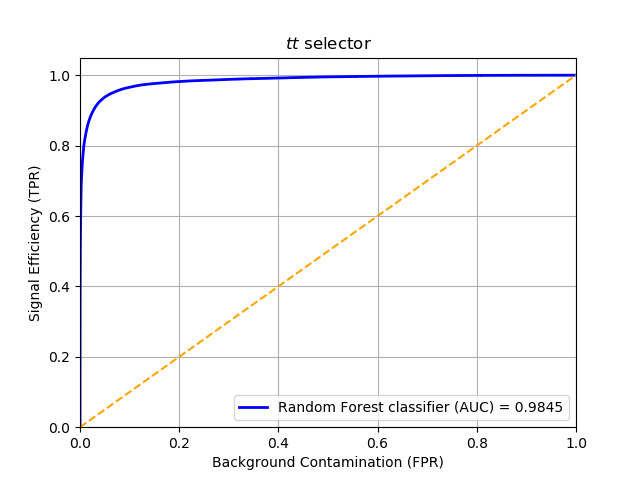

In [88]:
import matplotlib.pyplot as plt
%matplotlib notebook

plt.figure()
plt.plot(fpr[1], tpr[1], color='blue', 
         lw=2, label='Random Forest classifier (AUC) = %0.4f' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='orange', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Background Contamination (FPR)')
plt.ylabel('Signal Efficiency (TPR)')
plt.title('$tt$ selector')
plt.legend(loc="lower right")
plt.grid()
plt.show()

<IPython.core.display.Javascript object>


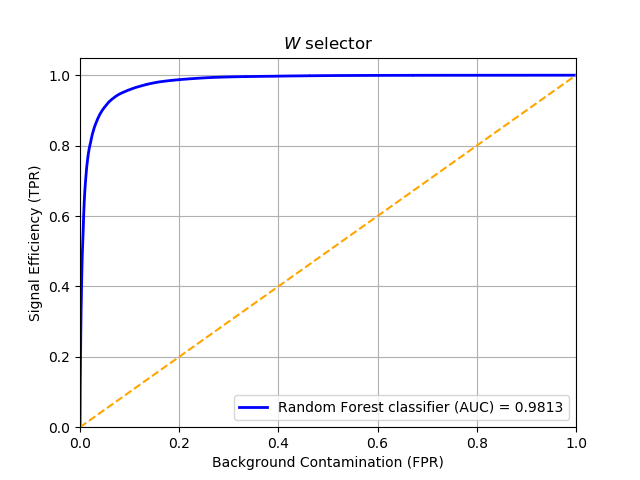

In [89]:
plt.figure()
plt.plot(fpr[2], tpr[2], color='blue', 
         lw=2, label='Random Forest classifier (AUC) = %0.4f' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='orange', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Background Contamination (FPR)')
plt.ylabel('Signal Efficiency (TPR)')
plt.title('$W$ selector')
plt.legend(loc="lower right")
plt.grid()
plt.show()